# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.715115,False,-3.518616
1,0.539078,True,5.061078
2,-1.839637,False,-5.943034
3,1.160872,True,8.991002
4,-0.385366,True,3.225390
...,...,...,...
995,-0.667065,False,-0.463410
996,-1.346482,False,-3.873697
997,-0.933737,False,-4.062597
998,-0.750176,True,1.468909


<Axes: xlabel='v0'>

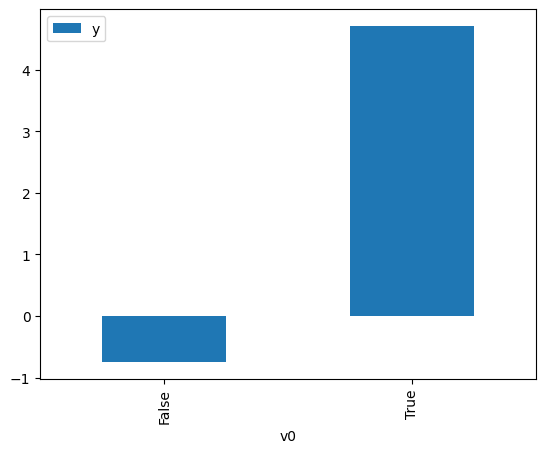

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

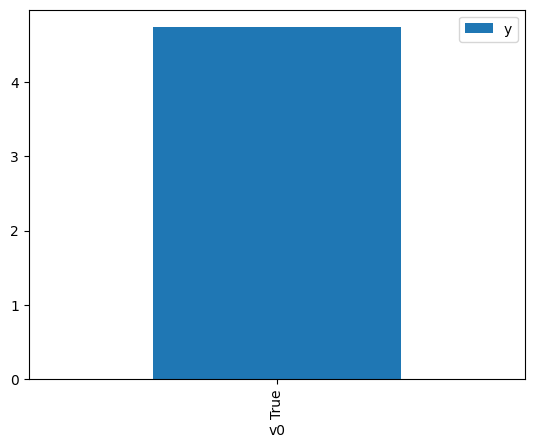

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.109906,False,-0.652486,0.534445,1.871101
1,-1.764162,False,-5.066081,0.955421,1.046659
2,0.101376,False,1.218693,0.441315,2.265954
3,-1.464478,False,-4.117739,0.926536,1.079289
4,0.430990,False,0.908529,0.305973,3.268265
...,...,...,...,...,...
995,0.777832,False,1.350279,0.192681,5.189936
996,0.520636,False,-0.065094,0.273363,3.658140
997,-0.666650,False,-2.705170,0.754554,1.325286
998,0.854264,False,2.069225,0.172513,5.796652


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.162336,True,6.577537,0.585085,1.709153
1,0.327106,True,5.241739,0.653670,1.529823
2,-0.438724,True,4.413208,0.327442,3.053978
3,1.985283,True,10.335020,0.972590,1.028183
4,-0.614370,True,2.907710,0.262977,3.802608
...,...,...,...,...,...
995,-0.279601,True,2.699210,0.392160,2.549977
996,-1.360500,True,-0.008255,0.087011,11.492758
997,-1.360500,True,-0.008255,0.087011,11.492758
998,0.571323,True,6.397281,0.744084,1.343933


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.130e+04
Date:                Thu, 24 Aug 2023   Prob (F-statistic):                        0.00
Time:                        16:26:31   Log-Likelihood:                         -1419.3
No. Observations:                1000   AIC:                                      2843.
Df Residuals:                     998   BIC:                                      2852.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7212      0.033     82.369      0.000       2.656       2.786
x2             4.9663      0.049    101.046      0.000       4.870       5.063
==============================================================================
Omnibus:                        0.074   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.122
Skew:                          -0.016   Prob(JB):                        0.941
Kurtosis:                       2.956   Cond. No.                         1.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""